# 텍스트 감정분석의 유용성
---
### 학습 목표
- 텍스트에 담긴 감성을 분석(Sentimental Analysis)하는 방법 학습
- 텍스트에 담긴 이용자의 감성이 긍정적인지 혹은 부정적인지를 분류(Classification) 할 수 있는 딥러닝 모델 구현
---
딥러닝을 이용한 텍스트 감성분석은 어떤 점에서 유용할까?
- 텍스트 데이터만이 가지고 있는 정보적 특성과 가치는 어떤 것일까?
- 감성분석 등 텍스트 분류 모델이 다른 데이터 분석 업무에 어떤 점에서 도움을 주나?
- 텍스트 데이터 분석의 기술적 어려움은?
- 텍스트 분류 작업을 하는데 딥러닝이 적용되면 어떤 점에서 유리해질까?

인공지능 모델을 입력과 출력이 정해진 함수라고 생각해 봅시다.   
예를 들어 MNIST 숫자 분류기 모델이라면 이미지 파일을 읽어 들인 매트릭스가 입력이 되고,   
이미지 파일에 쓰여 있는 실제 숫자 값이 출력이 되는 함수가 될 것입니다.  
이제 텍스트 문장을 입력으로 받아서 그 의미가 긍정이면 1, 부정이면 0을 출력하는 인공지능 모델을 만든다고 생각해 봅시다.   
이 모델을 만들기 위해서는 숫자 분류기를 만들 때는 생각할 필요가 없었던 2가지 문제가 생깁니다.  
- 텍스트를 어떻게 숫자 행렬로 표현할 수 있나요?  
- 텍스트에는 순서가 중요합니다. 입력 데이터의 순서를 인공지능 모델에 어떻게 반영해야 하나요?  

## 텍스트 데이터의 특징
인공지능 모델의 입력이 될 수 있는 것은 0과 1의 비트로 표현 가능한 숫자만으로 이루어진 매트릭스일 뿐
- 그 자체로는 기호일 뿐 텍스트가 내포하는 의미를 기호가 직접 내포하지 않는다
- 단어 사전을 만들고 그 단어의 의미를 나타내는 벡터를 짝지어 보려고 하는 것
- 딥러닝을 통해 그 벡터를 만들어 낼 수 있다.  

### 텍스트를 숫자로 표현하는 방법
- index_to_word 딕셔너리 : 단어를 인덱스로 변환
- get_encoded_sentence(sentence, word_to_index) 함수 : 문장을 숫자 리스트로 encoding
- get_decoded_sentence(encoded_sentence, index_to_word) 함수 : 숫자 리스트를 문장으로 decoding
- get_encoded_sentences(sentences, word_to_index) 함수 : 여러 문장을 encoding
- get_decoded_sentences(encoded_sentences, index_to_word) : 여러 문장의 encoded 데이터를 문장 리스트로 decoding


In [2]:
# 처리해야 할 문장 리스트
sentences=['i feel hungry', 'i eat lunch', 'now i feel happy']

# 파이썬 split() 메소드를 이용해 단어 단위로 문장을 쪼개 봅니다.
word_list = 'i feel hungry'.split()

index_to_word={}  # 빈 딕셔너리를 만들어서

# 단어들을 하나씩 채워 봅니다. 
# 채우는 순서는 일단 임의로 하였습니다. 그러나 사실 순서는 중요하지 않습니다. 
# <BOS>, <PAD>, <UNK>는 관례적으로 딕셔너리 맨 앞에 넣어줍니다. 
index_to_word[0]='<PAD>'  # 패딩용 단어
index_to_word[1]='<BOS>'  # 문장의 시작지점
index_to_word[2]='<UNK>'  # 사전에 없는(Unknown) 단어
index_to_word[3]='i'
index_to_word[4]='feel'
index_to_word[5]='hungry'
index_to_word[6]='eat'
index_to_word[7]='lunch'
index_to_word[8]='now'
index_to_word[9]='happy'

word_to_index={word:index for index, word in index_to_word.items()}

# 단어 'feel'은 숫자 인덱스 4로 바뀝니다.
# print(word_to_index['feel'])  

# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트로 변환해 주는 함수
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 문장 리스트를 한꺼번에 숫자 텐서로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]


### Embedding 레이어
텍스트가 숫자로 변환되어 인공지능 모델의 입력으로 사용될 수 있게 되었지만, 이것으로 충분하지는 않습니다.  
우리가 하려는 것은 단어와 그 단어의 의미를 나타내는 벡터를 짝짓는 것  
그래서 단어의 의미를 나타내는 벡터를 훈련 가능한 파라미터로 놓고 이를 딥러닝을 통해 학습해서 최적화
**Tensorflow, Pytorch** 등의 딥러닝 프레임워크들은 이러한 의미 벡터 파라미터를 구현한 **Embedding 레이어**를 제공합니다.  

**자연어 처리(Natural Language Processing)**분야에서 **임베딩(Embedding)**이란?  
- 사람이 쓰는 자연어를 기계가 이해할 수 있는 숫자형태인 vector로 바꾼 결과 혹은 그 일련의 과정 전체
- 가장 간단한 형태의 임베딩은 단어의 빈도를 그대로 벡터로 사용하는 것  

임베딩을 통해 할수있는 것  
- 단어나 문장 사이의 **코사인 유사도**가 가장 높은 단어를 구하는 등의 계산  
- 벡터 간 연산으로 단어 사이의 의미/문법적 관계 도출, **전이 학습(transfer learning)**
- 임베딩은 다른 딥러닝 모델의 입력값으로 자주 쓰이고, 품질 좋은 임베딩을 쓸수록 모델의 성능이 좋아진다.  

#### 텍스트 데이터를 워드 벡터 텐서 형태로 다시 표현하기

In [3]:
import numpy as np
import tensorflow as tf

####################
# input 문장 벡터
####################
raw_inputs = np.array(get_encoded_sentences(sentences, word_to_index), dtype='object') # Error 발생
''' >> raw_inputs의 3개 벡터의 길이는 각각 4, 4, 5입니다.
숫자로 변환된 텍스트 데이터 [[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]] 에 Embedding 레이어를 적용 시 Error 발생

Embedding 레이어의 인풋이 되는 문장 벡터는 그 길이가 일정해야 한다.     
    Tensorflow - tf.keras.preprocessing.sequence.pad_sequences 함수
    - 문장 벡터 뒤에 패딩(<PAD>)을 추가하여 길이를 일정하게 맞춰주는 기능을 제공
'''
raw_inputs = tf.keras.preprocessing.sequence.pad_sequences(raw_inputs,
                                                       value=word_to_index['<PAD>'],
                                                       padding='post',
                                                       maxlen=5)
print(raw_inputs)

####################
# embeding
####################
vocab_size = len(word_to_index) # 위 예시에서 딕셔너리에 포함된 단어 개수는 10개
word_vector_dim = 4     # output_dim : 4차원의 워드 벡터를 가정
embedding = tf.keras.layers.Embedding(input_dim = vocab_size, 
                                    output_dim = word_vector_dim, 
                                    mask_zero=True)
output = embedding(raw_inputs)
print(output)

[[1 3 4 5 0]
 [1 3 6 7 0]
 [1 8 3 4 9]]
tf.Tensor(
[[[ 0.01800824  0.00109091 -0.03690145 -0.02782474]
  [ 0.03383782  0.03039202 -0.00958464  0.03702618]
  [-0.01402246  0.03826613  0.04718358  0.00645492]
  [ 0.02545371  0.03254351  0.02317086 -0.00195549]
  [ 0.01135433 -0.02648982  0.00486221  0.03569087]]

 [[ 0.01800824  0.00109091 -0.03690145 -0.02782474]
  [ 0.03383782  0.03039202 -0.00958464  0.03702618]
  [-0.01964334  0.04169286 -0.01786273 -0.01151594]
  [-0.03981721 -0.01488172 -0.04473669 -0.04408164]
  [ 0.01135433 -0.02648982  0.00486221  0.03569087]]

 [[ 0.01800824  0.00109091 -0.03690145 -0.02782474]
  [ 0.0076717   0.00954638  0.02973614 -0.00288798]
  [ 0.03383782  0.03039202 -0.00958464  0.03702618]
  [-0.01402246  0.03826613  0.04718358  0.00645492]
  [ 0.02231213 -0.01300167  0.04575387 -0.0294359 ]]], shape=(3, 5, 4), dtype=float32)


- output shape=(3,5,4) : 3개의 입력 문장, 입력 문장 최대 길이 5, 워드 벡터 차원 수 4
---
## RNN(Recurrent Neural Network)
**시퀀스(Sequence)** 형태의 데이터를 처리하기에 최적인 모델
- 시퀀스 데이터 : 순서에 따라 배열된 데이터(음성신호, 시계열 데이터 등)
**내부에 순환 구조** : 이전 단계에서 계산한 정보를 현재 단계의 입력으로 사용 가능
- 과거의 정보를 기억하고 현재 입력에 대해 컨텍스트를 이해할 수 있는 장점을 제공

RNN은 각 단계에서 입력 데이터와 이전 단계의 **은닉 상태(hidden state)** 를 활용하여 출력을 계산한다.  
이전 단계의 은닉 상태는 현재 단계에서의 출력에 영향을 줄 뿐만 아니라, 다음 단계의 입력으로도 사용됩니다.  
이러한 반복 과정을 통해 RNN은 시퀀스 데이터의 잠재적인 패턴을 학습하고 예측할 수 있습니다.  

RNN은 주로 자연어 처리(Natural Language Processing)와 관련된 작업에 활용됩니다.
- 기계 번역, 문장 생성, 감성 분석 등에 RNN을 사용하여 문맥을 파악하고 다음 단계의 출력을 생성할 수 있습니다.   

RNN의 변종으로는 **LSTM(Long Short-Term Memory)** 과 **GRU(Gated Recurrent Unit)** 가 있으며,  
이들은 **RNN의 기울기 소실 문제(Vanishing Gradient Problem)** 를 완화하기 위해 개발된 구조입니다.


In [4]:
vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 4)           40        
                                                                 
 lstm (LSTM)                 (None, 8)                 416       
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 537
Trainable params: 537
Non-trainable params: 0
_________________________________________________________________


### RNN 대신 1-D CNN
우리는 이미지 분류기를 구현하면서 2-D CNN을 이미 사용해 본 바 있습니다.   
이미지는 시퀀스 데이터가 아닙니다. 이미지 분류기 모델에는 이미지 전체가 한꺼번에 입력으로 사용됩니다.  

**1-D Convolution Neural Network(1-D CNN)** : 텍스트를 처리하기 위해 사용 가능
- 문장 전체를 한꺼번에 한 방향으로 길이 7짜리 필터로 스캐닝
- 7단어 이내에서 발견되는 특징을 추출하여 문장을 분류
- RNN 계열보다 병렬처리가 효율적 >> 학습 속도도 훨씬 빠르게 진행

In [5]:
vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 4)           40        
                                                                 
 conv1d (Conv1D)             (None, None, 16)          464       
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 16)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 16)          1808      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 8)                

### 아주 간단히는 GlobalMaxPooling1D() 레이어 하나만 사용하는 방법
- 전체 문장 중에서 단 하나의 가장 중요한 단어만 피처로 추출
- 그것으로 문장의 긍정/부정을 평가하는 방식
- 의외로 성능이 잘 나올 수도 있습니다.

In [6]:
vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 4)           40        
                                                                 
 global_max_pooling1d_1 (Glo  (None, 4)                0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 8)                 40        
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


이 외에도 다양한 시도 가능
- 1-D CNN과 RNN 레이어를 섞어 사용
- FFN(FeedForward Network) 레이어만으로 구성
- 최근 각광받고 있는 Transformer 레이어 사용
---
## IMDB 영화리뷰 감성분석
**IMDb Large Movie Dataset**
- 50000개의 영어로 작성된 영화 리뷰 텍스트로 구성
- 긍정은 1, 부정은 0의 라벨
- 50000개의 리뷰 중 절반인 25000개가 훈련용 데이터, 나머지 25000개를 테스트용 데이터로 사용하도록 지정
- 이 데이터셋은 tensorflow Keras 데이터셋 안에 포함되어 있어서 손쉽게 다운로드하여 사용할 수 있습니다.

### 데이터 가져오기
tf.keras.datasets.imdb - load_data(num_words)  
- num_words: 단어 사전에 등재할 단의 개수 >> 지정 개수 만큼의 word_to_index 딕셔너리 생성
- encode된 텍스트 데이터를 다운로드
- encode시 사용한 딕셔너리 제공 : imdb.get_word_index()

In [7]:
imdb = tf.keras.datasets.imdb

# IMDb 데이터셋 다운로드 
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)
print(f"훈련 샘플 개수: {len(x_train)}, 테스트 개수: {len(x_test)}")
print(x_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(x_train[0]))
print('2번째 리뷰 문장 길이: ', len(x_train[1]))

# word_to_index
word_to_index = imdb.get_word_index()
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word[1])     # 'the' 가 출력됩니다. 
print(word_to_index['the'])  # 1 이 출력됩니다.


훈련 샘플 개수: 25000, 테스트 개수: 25000
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
라벨:  1
1번째 리뷰 문장 길이:  218
2번째

word_to_index 보정 필요

In [8]:
# 보정 전 x_train[0] 데이터
print(get_decoded_sentence(x_train[0], index_to_word))

##################################### 보정 작업
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다.
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # '<BOS>' 가 출력됩니다. 
print(word_to_index['the'])  # 4 이 출력됩니다. 
print(index_to_word[4])     # 'the' 가 출력됩니다.

# 보정 후 x_train[0] 데이터
print(get_decoded_sentence(x_train[0], index_to_word))


as you with out themselves powerful lets loves their becomes reaching had journalist of lot from anyone to have after out atmosphere never more room and it so heart shows to years of every never going and help moments or of every chest visual movie except her was several of enough more with is now current film as you of mine potentially unfortunately of you than him that with out themselves her get for was camp of you movie sometimes movie that with scary but and to story wonderful that in seeing in character to of 70s musicians with heart had shadows they of here that with her serious to have does when from why what have critics they is you that isn't one will very to as itself with other and in of seen over landed for anyone of and br show's to whether from than out themselves history he name half some br of and odd was two most of mean for 1 any an boat she he should is thought frog but of script you not while history he heart to real at barrel but when from one bit then have two of

In [9]:
# decode 테스트
print(get_decoded_sentence(x_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they h

문장 최대 길이 maxlen 값 설정을 위한 적절한 값 찾아야 한다 >> 전체 모델 성능에 영향
- 전체 데이터셋 분포 확인

In [10]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  234.75892
문장길이 최대 :  2494
문장길이 표준편차 :  172.91149458735703
pad_sequences maxlen :  580
전체 문장의 0.94536%가 maxlen 설정값 이내에 포함됩니다. 


padding 방식에 따라 RNN을 이용한 딥러닝 적용 시 성능 차이가 발생
- 앞쪽('pre') 가 유리하다 : post padding 보다 10% 이상의 테스트 성능 차이 발생
- 문장 뒤쪽('post') : 마지막 입력이 무의미한 padding인 경우 비효율적

In [11]:
## post padding 데이터
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(25000, 580)


### RNN 모델 설계

In [12]:
# RNN 모델 설계
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 16)          160000    
                                                                 
 lstm_1 (LSTM)               (None, 8)                 800       
                                                                 
 dense_6 (Dense)             (None, 8)                 72        
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


모델 훈련 전 검증셋(validation set) 분리 
- 훈련용 데이터 셋 25000건 중 10000건 분리

In [13]:
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(15000, 580)
(15000,)


In [14]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 27s 728ms/step - loss: 0.6933 - accuracy: 0.4977 - val_loss: 0.6931 - val_accuracy: 0.5018
Epoch 2/20
30/30 [==============================] - 22s 745ms/step - loss: 0.6931 - accuracy: 0.5052 - val_loss: 0.6932 - val_accuracy: 0.5011
Epoch 3/20
30/30 [==============================] - 26s 859ms/step - loss: 0.6928 - accuracy: 0.5209 - val_loss: 0.6931 - val_accuracy: 0.5035
Epoch 4/20
30/30 [==============================] - 21s 699ms/step - loss: 0.6924 - accuracy: 0.5072 - val_loss: 0.6929 - val_accuracy: 0.5032
Epoch 5/20
30/30 [==============================] - 21s 679ms/step - loss: 0.6896 - accuracy: 0.5131 - val_loss: 0.6909 - val_accuracy: 0.5033
Epoch 6/20
30/30 [==============================] - 22s 726ms/step - loss: 0.6823 - accuracy: 0.5261 - val_loss: 0.6854 - val_accuracy: 0.5170
Epoch 7/20
30/30 [==============================] - 18s 598ms/step - loss: 0.6728 - accuracy: 0.5495 - val_loss: 0.6932 - val_accuracy: 0.5069

테스트 데이터로 평가

In [15]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 31s - loss: 0.5923 - accuracy: 0.7250 - 31s/epoch - 40ms/step
[0.5923455953598022, 0.7250400185585022]


In [16]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [17]:
# import matplotlib.pyplot as plt
# import os    
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

# acc = history_dict['accuracy']
# val_acc = history_dict['val_accuracy']
# loss = history_dict['loss']
# val_loss = history_dict['val_loss']

# epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
# plt.plot(epochs, loss, 'bo', label='Training loss')
# # b는 "파란 실선"입니다
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.show()

In [ ]:
# plt.clf()   # 그림을 초기화합니다

# plt.plot(epochs, acc, 'bo', label='Training acc')
# plt.plot(epochs, val_acc, 'b', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.show()

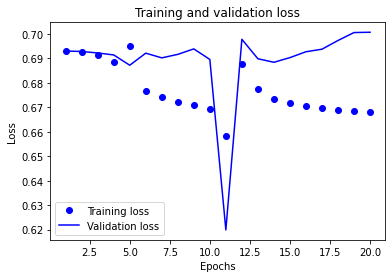
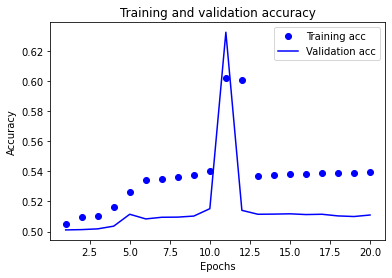

### 학습한 Embeding 파라미터 저장

In [18]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = './data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

(10000, 16)


### 파라메터를 읽어 word vector로 활용
gensim - Word2VecKeyedVectors
- 유사도 확인 가능 : similar_by_word

In [19]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['computer']
vector

array([ 0.01401771, -0.05854594, -0.00291623, -0.03366603,  0.01186193,
       -0.03479581,  0.07233099, -0.02694851,  0.01523762,  0.05468585,
        0.07342264,  0.00950327, -0.06672791,  0.06683458,  0.07555837,
        0.00774099], dtype=float32)

In [20]:
# 유사도 확인
word_vectors.similar_by_word("love")

[('bag', 0.9091659188270569),
 ('wet', 0.8806669116020203),
 ('electricity', 0.8776379823684692),
 ('cruelty', 0.8766930103302002),
 ('talks', 0.8762642741203308),
 ('news', 0.8710636496543884),
 ('coffee', 0.8709262013435364),
 ('23', 0.8704927563667297),
 ('pleasantly', 0.8665190935134888),
 ('seal', 0.8650901317596436)]

### 구글 Word2Vec 모델 적용
gensim - KeyedVectors

In [21]:
from gensim.models import KeyedVectors

word2vec_path = './data/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['computer']
vector     # 무려 300dim의 워드 벡터입니다.

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

In [22]:
# 유사도 확인 - 메모리를 다소 많이 소비하는 작업 유의!!
word2vec.similar_by_word("love")

[('loved', 0.6907791495323181),
 ('adore', 0.6816873550415039),
 ('loves', 0.661863386631012),
 ('passion', 0.6100708842277527),
 ('hate', 0.6003956198692322),
 ('loving', 0.5886635780334473),
 ('affection', 0.5664337873458862),
 ('undying_love', 0.5547305345535278),
 ('absolutely_adore', 0.5536840558052063),
 ('adores', 0.5440906882286072)]

### 모델 임베딩 레이어 Word2Vec로 교체

In [23]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

### 모델 구성

In [24]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 580, 300)          3000000   
                                                                 
 conv1d_2 (Conv1D)           (None, 574, 16)           33616     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 114, 16)          0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 108, 16)           1808      
                                                                 
 global_max_pooling1d_2 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_8 (Dense)             (None, 8)                

In [25]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 54s 2s/step - loss: 0.6861 - accuracy: 0.5425 - val_loss: 0.6863 - val_accuracy: 0.5474
Epoch 2/20
30/30 [==============================] - 47s 2s/step - loss: 0.6414 - accuracy: 0.6437 - val_loss: 0.6159 - val_accuracy: 0.6842
Epoch 3/20
30/30 [==============================] - 48s 2s/step - loss: 0.5124 - accuracy: 0.7849 - val_loss: 0.4835 - val_accuracy: 0.7587
Epoch 4/20
30/30 [==============================] - 57s 2s/step - loss: 0.3649 - accuracy: 0.8499 - val_loss: 0.3447 - val_accuracy: 0.8583
Epoch 5/20
30/30 [==============================] - 70s 2s/step - loss: 0.2534 - accuracy: 0.9091 - val_loss: 0.3149 - val_accuracy: 0.8660
Epoch 6/20
30/30 [==============================] - 75s 3s/step - loss: 0.1914 - accuracy: 0.9335 - val_loss: 0.3021 - val_accuracy: 0.8704
Epoch 7/20
30/30 [==============================] - 74s 2s/step - loss: 0.1420 - accuracy: 0.9571 - val_loss: 0.3095 - val_accuracy: 0.8690
Epoch 8/20
30/30 [==

In [26]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)
print(results)

782/782 - 26s - loss: 0.5035 - accuracy: 0.8629 - 26s/epoch - 33ms/step
[0.5035013556480408, 0.8628799915313721]
